In [1]:
# 파이토치로 구현한 손글씨 데이터셋 모델
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 학습 데이터셋을 내려받음
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# 데이터로더를 생성, 텐서에서는 데이터 셋
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
  print('Shape of X [N, C, H, W] : ', X.shape)
  print('Shape of y : ', y.shape, y.dtype)
  print(test_dataloader)
  print(y)
  break

Shape of X [N, C, H, W] :  torch.Size([64, 1, 28, 28])
Shape of y :  torch.Size([64]) torch.int64
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


In [4]:
# 학습에 사용할 CPU장치나 GPU장치를 얻음
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('사용중인 디바이스 : {}'.format(device))

사용중인 디바이스 : cuda


In [5]:
# 모델을 정의
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 10)
    )
  
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [6]:
# Linear(in_features=784, out_features=128, bias=True)
# bias = True : 해당 in_features, out_features에 의해 layer는 자동으로 학습함
# bias = False : 해당 in_features, out_features에 의해 layer는 자동으로 학습하지 않음
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [7]:
# Loss 함수와 Optimizer 설정
# parameters() : iterator 객체를 반환

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
# Training을 위한 함수
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # 예측 오류 계산
    pred = model(X)
    loss = loss_fn(pred, y)

    # 역전파(Back-Propagation)
    # 컴퓨터가 예측값의 정확도를 높이기 위해서 출력값과 실제 예측하고자 하는 값을 비교해서 가중치를 변경하는 작업
    # 1. 주어진 입력값에 상관없이 임의의 초기 가중치를 준 뒤 은닉층을 거쳐 결과를 계산
    # 2. 계산 결과와 실제 예측하고자 하는 값 사이의 오차를 구함
    # 3. 가중치를 업데이트
    # 4. 1~3의 과정을 오차가 더이상 줄지 않을 때까지 반복

    # AI에서 학습이란? 기울기(Gradient)가 작아지는 방향으로 업데이트를 반복하는 것
    # 경사하강법(Gradient Descent)
    # 학습할 때 사용되는 전체 데이터를 미분하여 기울기가 낮은 쪽으로 계속 이동시켜 극값을 구하면 이것을 
    # 근사값(예측값)으로 확정하는 원리, 한 번 업데이트 할 때마다 전체 데이터를 미분해야 하기 때문에 진행속도가 느림
    # SGD(확률적 경사 하강법) : 램덤 추출된 일부 데이터를 사용하여, 오차를 수정하기 전 수정값과 방향(+, -) 
    # 참고하고 변경시키는 방법
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

In [9]:
# Test를 위한 함수
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  # print(size)
  num_batches = len(dataloader)
  # Dropout layer 학습시에만 동작해야 함.
  model.eval()
  test_loss, current = 0, 0
  # autograd를 사용하지 않음으로 메모리 사용량을 줄이고 연산 속도를 높임
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      current += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    current /= size
    print(f'Test Error: \n Acrruacy: {(100*current):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [10]:
epochs = 10
for t in range(epochs):
  print(f'Epoch {t + 1}\--------------')
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print('끝')

'''
Epoch 1\--------------
loss: 2.319400 [    0/60000]
loss: 0.481557 [ 6400/60000]
loss: 0.344131 [12800/60000]
loss: 0.396380 [19200/60000]
loss: 0.264298 [25600/60000]
loss: 0.352764 [32000/60000]
loss: 0.165770 [38400/60000]
loss: 0.355946 [44800/60000]
loss: 0.312985 [51200/60000]
loss: 0.309072 [57600/60000]

Accuracy: 94.2%, Avg loss: 0.188341
'''

Epoch 1\--------------
loss: 2.327269 [    0/60000]
loss: 0.445938 [ 6400/60000]
loss: 0.289274 [12800/60000]
loss: 0.382340 [19200/60000]
loss: 0.210392 [25600/60000]
loss: 0.379578 [32000/60000]
loss: 0.199019 [38400/60000]
loss: 0.388829 [44800/60000]
loss: 0.263654 [51200/60000]
loss: 0.357838 [57600/60000]
Test Error: 
 Acrruacy: 93.9%, Avg loss: 0.199186 

Epoch 2\--------------
loss: 0.127268 [    0/60000]
loss: 0.200062 [ 6400/60000]
loss: 0.108548 [12800/60000]
loss: 0.213714 [19200/60000]
loss: 0.151580 [25600/60000]
loss: 0.235276 [32000/60000]
loss: 0.063511 [38400/60000]
loss: 0.255585 [44800/60000]
loss: 0.194325 [51200/60000]
loss: 0.202095 [57600/60000]
Test Error: 
 Acrruacy: 96.2%, Avg loss: 0.128872 

Epoch 3\--------------
loss: 0.077684 [    0/60000]
loss: 0.125023 [ 6400/60000]
loss: 0.085745 [12800/60000]
loss: 0.111299 [19200/60000]
loss: 0.100276 [25600/60000]
loss: 0.173996 [32000/60000]
loss: 0.046080 [38400/60000]
loss: 0.182768 [44800/60000]
loss: 0.143427 

'\nEpoch 1\\--------------\nloss: 2.319400 [    0/60000]\nloss: 0.481557 [ 6400/60000]\nloss: 0.344131 [12800/60000]\nloss: 0.396380 [19200/60000]\nloss: 0.264298 [25600/60000]\nloss: 0.352764 [32000/60000]\nloss: 0.165770 [38400/60000]\nloss: 0.355946 [44800/60000]\nloss: 0.312985 [51200/60000]\nloss: 0.309072 [57600/60000]\n\nAccuracy: 94.2%, Avg loss: 0.188341\n'

In [13]:
import os
from PIL import Image
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys() : 
  print('file : {name}, length : {length}bytes'.format(name=fn, length=len(uploaded[fn])))

Saving 4043232_avatar_batman_comics_hero_icon.png to 4043232_avatar_batman_comics_hero_icon.png
file : 4043232_avatar_batman_comics_hero_icon.png, length : 5491bytes


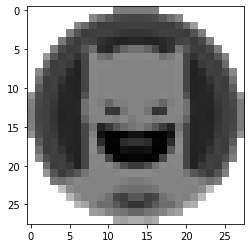

In [15]:
cur_dir = os.getcwd()
img_path = os.path.join(cur_dir, 'image5.png')

cur_img = Image.open(img_path)

cur_img = cur_img.resize((28, 28))
image = np.asarray(cur_img)

try : 
  image = np.mean(image, axis=2)
except : 
  pass

image = np.abs(255-image)
image = image.astype(np.float32) / 255.
plt.imshow(image, cmap='gray')
plt.show()

In [16]:
image = torch.as_tensor(image).to(device).reshape(1, 1, 28, 28)
model.eval()
predict = model(image)
print('model이 예측한 값 : {}'.format(predict.argmax(1).item()))

model이 예측한 값 : 3


In [17]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



3092
26482
1487
13516
28897
14151
45154
34217
19287


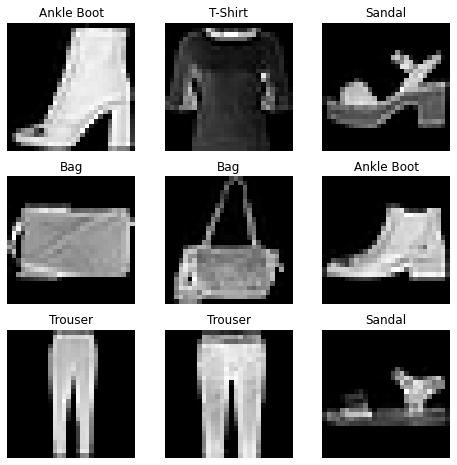

In [18]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1) : 
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  print(sample_idx)
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray') # 채널을 없애준다 (1 (컬러 채널)을 삭제하고, 28 * 28 사이즈로 출력한다.)
plt.show()
# 채널을 생성 = unsqueeze()

In [19]:
# DataLoader 만들기
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape : torch.Size([64, 1, 28, 28])
Label batch shape : torch.Size([64])


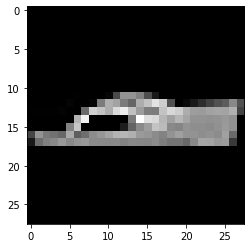

Label : 5


In [20]:
train_features, train_labels = next(iter(train_dataloader)) # iter : 데이터 로더를 통해 반복하여 학습하는 함수
print(f'Feature batch shape : {train_features.size()}')
print(f'Label batch shape : {train_labels.size()}')

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label : {label}')
# f = formatter, print 안에 중괄호를 넣어 변수처리를 할 수 있다.

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'사용하는 디바이스는 {device} 입니다.')

사용하는 디바이스는 cuda 입니다.


In [22]:
# Model class 생성
class NeuralNetwork(nn.Module) :
  # 뉴럴 네트워크.모델 을 상속받아 모델을 구현한다.
  def __init__(self) :  # 생성자
    super(NeuralNetwork, self).__init__() # 뉴럴 네트워크 모듈을 호출하여, 부모 클래스의 생성자를 호출한다.
    self.flatten = nn.Flatten() # nn.flatten 객체를 생성한다.
    self.linear_relu_stack = nn.Sequential( # 하이퍼 파라미터를 포함하는 시퀀셜 객체를 생성한다.
                                            # 레이어를 쌓는다. tensorflow의 dense layer 와 비슷하다.
                                            # dense layer : 연산이 일어나는 레이어로, 비슷하지만, 연산이 일어나는 레이어는 렐루, 드롭아웃 2 개 밖에 없다.
        nn.Linear(28*28, 128), # 크기, 파라미터 선언 (인풋 레이어, 연산 레이어가 아니므로 딥러닝 레이어에 포함되지 않는다.)
        nn.ReLU(), # 렐루 함수를 호출
        nn.Dropout(0.2), # 드롭아웃 비율
        nn.Linear(128, 10) # 128 개의 파라미터, 10 개의 리턴(출력) (아웃풋 레이어)
    )

  def forward(self, x) : # 객체를 생성하여 실행하면 출력되는 함수
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [23]:
# Model 객체 생성
model = NeuralNetwork().to(device) # 생성자가 실행
print(model) # 포워드 함수가 실행

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [35]:
# 가상의 데이터를 만들어서 예측하기
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
# 결과값 
print(logits) # 랜덤한 값을 10 개 뽑아서 출력한다. (학습 내용이 없기 때문)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f'예측된 클래스 : {y_pred}')

tensor([[ -9.1159,  -4.3935,  -2.9931,  -5.0683,  -1.2295, -19.5718,  -4.7347,
         -20.2822,   8.1953, -11.9998]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
예측된 클래스 : tensor([8], device='cuda:0')


In [36]:
loss_fn = nn.CrossEntropyLoss()

In [37]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
def train_loop(dataloader, model, loss_fn, optimizer) : 
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    # 예측, 손실 계산
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad() # 역전파가 발생할 시 값을 초기화 시켜주기 위해 사용한다.
    # gradient 값을 backward 할 때 오차값이 누적된다.(모델 특성) 
    # loss.backward 를 호출할 때 초기 설정을 더해주기 때문에 한 번의 학습이 끝나면 값을 0으로 초기화해 주는 역할을 한다.
    loss.backward() # 역전파가 발생한다. (레이어를 거쳐가며 연산을 진행할 때 역전파가 발생한다.)
    optimizer.step() # 기울기의 값을 업데이트한다.

    if batch % 100 == 0 : 
      loss, current = loss.item(), batch * len(X)
      print(f'loss:{loss:>7f} [{current:>5d}/{size:>5d}]') # 7자리 소수, 5자리 정수, 5자리 정수

In [53]:
def test_loop(dataloader, model, loss_fn) : 
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, current = 0, 0 # 값 초기화

  model.eval() # 학습할 때 사용하는 함수를 비활성화
 
  with torch.no_grad() : # 메모리를 절약하기 위해 사용한다.
    for X, y in dataloader : 
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item() # 로스값을 누적시킨다.
      current += (pred.argmax(1) == y).type(torch.float).sum().item() # 가장 큰 값을 뽑아 누적시킨다.

    test_loss /= num_batches    
    current /= size

    print(f'Test Finished : \n Accuracy : {(100 * current):>0.1f}%, Avg loss : {test_loss:>8f} \n') # 백분율을 00.0% 까지, test_loss 를 0.000000 까지로 끊음 (소숫점 8자리 전까지)

In [54]:
# 학습을 진행
epochs = 10
for t in range(epochs) : 
  print(f'Epoch {t + 1}\--------------------------')
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print('학습 종료')

Epoch 1\--------------------------
loss: 0.205611 [    0/60000]
loss: 0.211694 [ 6400/60000]
loss: 0.183927 [12800/60000]
loss: 0.052027 [19200/60000]
loss: 0.113576 [25600/60000]
loss: 0.085118 [32000/60000]
loss: 0.175482 [38400/60000]
loss: 0.063203 [44800/60000]
loss: 0.132508 [51200/60000]
loss: 0.084568 [57600/60000]
Test Error: 
 Acrruacy: 88.9%, Avg loss: 0.377847 

Epoch 2\--------------------------
loss: 0.183819 [    0/60000]
loss: 0.113287 [ 6400/60000]
loss: 0.193202 [12800/60000]
loss: 0.155162 [19200/60000]
loss: 0.134352 [25600/60000]
loss: 0.095647 [32000/60000]
loss: 0.139627 [38400/60000]
loss: 0.100582 [44800/60000]
loss: 0.096869 [51200/60000]
loss: 0.115607 [57600/60000]
Test Error: 
 Acrruacy: 89.1%, Avg loss: 0.379454 

Epoch 3\--------------------------
loss: 0.160665 [    0/60000]
loss: 0.094096 [ 6400/60000]
loss: 0.138356 [12800/60000]
loss: 0.208293 [19200/60000]
loss: 0.049991 [25600/60000]
loss: 0.140500 [32000/60000]
loss: 0.222362 [38400/60000]
loss: 0.

In [ ]:
# 학습된 모델의 파라미터를 저장한다.
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# 새 model instance 를 생성하여 학습되지 않은 상태를 확인한다.
model2 = NeuralNetwork().to(device)
print(model2)

In [ ]:
# 테스트
model2.eval()
test_loop(test_dataloader, model2, loss_fn)

In [ ]:
# 저장된 파라미터를 불러와 모델에 적용한다.
model2.load_state_dict(torch.load('model_weights.pth'))

model2.eval()
test_loop(test_dataloader, model2, loss_fn)

In [ ]:
# 모델 자체를 저장하고 불러오기
torch.save(model, 'model.pth')

In [ ]:
# 모델 자체를 불러와 테스트하기
model3 = torch.load('model.pth')

model3.eval()
test_loop(test_dataloader, model3, loss_fn)